In [ ]:
import geopandas as gpd
import pandas as pd
import folium
import pyproj
from shapely.geometry import Point
import shapely
import matplotlib.pyplot as plt
import re
from tqdm.notebook import tqdm
import numpy as np
import seaborn as sns

In [ ]:
import matplotlib.font_manager as fm
import matplotlib as mpl

fm.fontManager.addfont('config/NanumSquareR.ttf')
prop = fm.FontProperties(fname='config/NanumSquareR.ttf')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

box_kwargs = dict(boxprops=dict(alpha=0.5), fliersize = 0)
strip_kwargs = dict(size=10)
bar_kwargs = dict(capsize = 0.1)
cormap_kwargs = dict(annot = True, cmap='coolwarm', vmin=-1, vmax=1)

In [ ]:
processing_data = pd.read_csv('data/data_241007.csv')

In [ ]:
processing_final = processing_data.copy()

processing_geo = gpd.GeoDataFrame(processing_final.assign(geometry = lambda df:df.apply(lambda row:shapely.geometry.Point((row.y, row.x)), axis=1)))
sgg_select = processing_geo.filter(regex='시도|시군구').drop_duplicates()\
.apply(lambda row: f"{row['시도']} {row['시군구'].split()[-1]}" if "부천" not in row['시군구'] 
       else f"{row['시도']} {' '.join(row['시군구'].split()[1:])}" , axis=1).tolist()

In [ ]:
seoul_geo = gpd.read_file('data/seoul_geo/LARD_ADM_SECT_SGG_11_202405.shx', encoding = 'cp949').query("SGG_NM in @sgg_select").to_crs('4326')
gyeonggi_geo = gpd.read_file('data/gyeonggi_geo/LARD_ADM_SECT_SGG_41_202405.shx', encoding = 'cp949').query("SGG_NM in @sgg_select").to_crs('4326')
incheon_geo = gpd.read_file('data/incheon_geo/LARD_ADM_SECT_SGG_28_202405.shx', encoding = 'cp949').query("SGG_NM in @sgg_select").to_crs('4326')

In [ ]:
total_geo = shapely.union_all([shapely.union_all(seoul_geo.geometry.values), shapely.union_all(incheon_geo.geometry.values), shapely.union_all(gyeonggi_geo.geometry.values)])

In [ ]:
## V-world api
# def find_coordinates(address, search_type ='road'):
#     import time
#     import requests
#     # time.sleep(1)
#     apiurl = "https://api.vworld.kr/req/address?"
#     params = {
#     	"service": "address",
#     	"request": "getcoord",
#     	"crs": "epsg:5186",
#     	"address": address,
#     	"format": "json",
#     	"type": search_type,
#     	"key": "{vworld-key}"
#     }
#     response = requests.get(apiurl, params=params)
#     if response.status_code == 200:
#         result = response.json()['response']
#         # print(result)
#         if 'result' in result.keys():
#             return result['result']['point']['x'], result['result']['point']['y']
#         else:
#             print(address)
#             return 0,0
#     else:
#         print(response.status_code)
#         print(address)
#         return 0,0

## kakao map api
import requests
def set_rest_api(rest_api_token):
    def convert_address_to_coordinates(address):
        """
        입력받은 주소를 WGS84 좌표계 좌표로 변환(카카오맵api)
        """
    
        url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + address
        
        header = {'Authorization': 'KakaoAK ' + rest_api_token}
     
        r = requests.get(url, headers=header)
        
        if (r.status_code == 200) and len(r.json()["documents"])>0:
            lng = float(r.json()["documents"][0]["address"]['x'])
            lat = float(r.json()["documents"][0]["address"]['y'])
        else:
            return None
        return lat, lng
        
    return convert_address_to_coordinates

kakao_api_key = ""
convert_address_to_coordinates = set_rest_api(kakao_api_key)

def find_coordi(address_):
    output = convert_address_to_coordinates(address_[0])
    return output if output else convert_address_to_coordinates(address_[1])

In [ ]:
import glob
stations = glob.glob('data/stations/*.xlsx')

In [ ]:
stations

['data/stations/공항철도_역사정보_20240529.xlsx',
 'data/stations/남서울경전철_역사정보_20240604.xlsx',
 'data/stations/서울교통공사_역사정보_20240529.xlsx',
 'data/stations/서울메트로9호선_역사정보_20240603.xlsx',
 'data/stations/신분당선_역사정보_20240605.xlsx',
 'data/stations/용인경량전철_역사정보_20240530.xlsx',
 'data/stations/인천교통공사_역사정보_20240528.xlsx',
 'data/stations/지티엑스에이운영_역사정보_20240418.xlsx',
 'data/stations/한국철도공사_역사정보_20240610.xlsx']

In [ ]:
stations_f0 = pd.read_excel(stations[-1]).filter(regex='운영노선|역명\(한글\)|역 주소')
total_stations = pd.concat([pd.read_excel(xls_f, skiprows=3).filter(regex='운영노선|역명\(한글\)|주소') for xls_f in stations[:-1]]+[stations_f0])

In [ ]:
total_stations

,운영노선,역명(한글),역 주소(지번주소),역 주소(도로명 주소)
0,공항철도선,서울역,NaN,서울특별시 용산구 청파로 378 (동자동) 공항철도 서울역
1,공항철도선,공덕,NaN,서울특별시 마포구 마포대로 지하 92(도화동) 공항철도 공덕역
2,공항철도선,홍대입구,NaN,서울특별시 마포구 양화로 지하 188(동교동) 공항철도 홍대입구역
3,공항철도선,디지털미디어시티(스카이라이프),NaN,서울특별시 마포구 성암로 지하 184(상암동) 공항철도 디지털미디어시티역
4,공항철도선,마곡나루,NaN,서울특별시 강서구 마곡중앙로 지하 135(마곡동)
...,...,...,...,...
296,1호선,화서,NaN,경기도 수원시 팔달구 덕영대로 692 _x000D_
297,3호선,화정역,경기도 고양시 덕양구 화정동 1098,경기도 고양시 덕양구 화정로 60
298,1호선,회기역,서울특별시 동대문구 휘경동 317-101,서울특별시 동대문구 회기로 196(휘경동)
299,1호선,회룡,경기도 의정부시 호원동 50-5(회룡역),경기도 의정부시 평화로 363(회룡역)


In [ ]:
stations_f = total_stations.assign(
    address = lambda df: df.apply(lambda row: row['역 주소(지번주소)'] if type(row['역 주소(도로명 주소)']) == float else row['역 주소(도로명 주소)'],axis=1),
    filter_YN = lambda df: df.address.apply(lambda y: False if type(y) ==float else  (True if re.search('서울|경기|인천|구리|고양|교양|수원', y) else False))
).query('filter_YN')

In [ ]:
stations_f

,운영노선,역명(한글),역 주소(지번주소),역 주소(도로명 주소),address,filter_YN
0,공항철도선,서울역,NaN,서울특별시 용산구 청파로 378 (동자동) 공항철도 서울역,서울특별시 용산구 청파로 378 (동자동) 공항철도 서울역,True
1,공항철도선,공덕,NaN,서울특별시 마포구 마포대로 지하 92(도화동) 공항철도 공덕역,서울특별시 마포구 마포대로 지하 92(도화동) 공항철도 공덕역,True
2,공항철도선,홍대입구,NaN,서울특별시 마포구 양화로 지하 188(동교동) 공항철도 홍대입구역,서울특별시 마포구 양화로 지하 188(동교동) 공항철도 홍대입구역,True
3,공항철도선,디지털미디어시티(스카이라이프),NaN,서울특별시 마포구 성암로 지하 184(상암동) 공항철도 디지털미디어시티역,서울특별시 마포구 성암로 지하 184(상암동) 공항철도 디지털미디어시티역,True
4,공항철도선,마곡나루,NaN,서울특별시 강서구 마곡중앙로 지하 135(마곡동),서울특별시 강서구 마곡중앙로 지하 135(마곡동),True
...,...,...,...,...,...,...
296,1호선,화서,NaN,경기도 수원시 팔달구 덕영대로 692 _x000D_,경기도 수원시 팔달구 덕영대로 692 _x000D_,True
297,3호선,화정역,경기도 고양시 덕양구 화정동 1098,경기도 고양시 덕양구 화정로 60,경기도 고양시 덕양구 화정로 60,True
298,1호선,회기역,서울특별시 동대문구 휘경동 317-101,서울특별시 동대문구 회기로 196(휘경동),서울특별시 동대문구 회기로 196(휘경동),True
299,1호선,회룡,경기도 의정부시 호원동 50-5(회룡역),경기도 의정부시 평화로 363(회룡역),경기도 의정부시 평화로 363(회룡역),True


-- 수정내역 
- 왕십리광장로 18 -> 왕십리광장로 17
- 상록수 -> 상록구 
- 안안로 -> 만안로
- 와부음 -> 와부읍
- 경기도 양주시 고덕호 139번길 317 -> 경기 양주시 덕계로 126 
- 교양시->고양시
- 인천광역시 연수구 벚꽂로 195 -> 인천 연수구 벚꽂로 195
- 인천광역시 미출홀구 경인로 129 -> 인천광역시 미추홀구 경인로 129
- 서울툭별시 -> 서울특별시
- 인천광역시 미추홀구 주안로 지하 91-1 -> 인천 미추홀구 주안동 125
- 경기도 부천시 길주로 713 -> 인천 부평구 길주로 지하 713
- 경기도 부천시 길주로 623 -> 인천 부평구 길주로 지하 623
- 경기도 부천시 길주로 379 -> 인천 부평구 길주로 지하 379
- 경기도 부천시 길주로 120 -> 인천 서구 길주로 지하 120

In [ ]:
def address_adjust(address):
    return re.sub(' 공항철도 .*역$| \(.*\)| [가-힣]*역$| [가-힣]*역\(.*\)$', '', re.search('[가-힣 0-9\-\(\)]*', address).group().strip()) if type(address)==str else ''

addresss = []
for i in tqdm(stations_f.filter(regex='주소').itertuples()):
    addresss.append((address_adjust(i[1]), address_adjust(i[2])))

In [ ]:
coordinates = []
for i, j in tqdm(addresss):
    coordinates.append(find_coordi([j if i=='' else i, j]))

In [ ]:
# check
[idx for idx, i in enumerate(coordinates) if i ==None]

In [ ]:
pd.concat([stations_f.reset_index(drop=True), pd.DataFrame(coordinates, columns = ['y','x'])], axis=1).to_csv('data/preprocessed_241007.csv', index=False, encoding='utf-8-sig')

In [ ]:
station_preprocessed = pd.read_csv('data/preprocessed_241007.csv')

In [ ]:
stations_geo = gpd.GeoDataFrame(station_preprocessed.assign(geometry = lambda df: df.apply(lambda row:shapely.geometry.Point((row.x, row.y)), axis=1)))\
.assign(filter_TF = lambda df: df.geometry.apply(lambda x: shapely.within(x, total_geo))).query('filter_TF')

In [ ]:
line_list = stations_geo['운영노선'].unique()
colors = sns.color_palette('tab10', len(line_list))

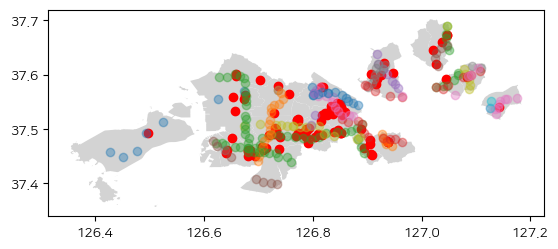

In [ ]:
fig, ax = plt.subplots()
seoul_geo.plot(ax=ax, color='lightgray')
gyeonggi_geo.plot(ax = ax, color='lightgray')
incheon_geo.plot(ax = ax, color='lightgray')
processing_geo.plot(ax=ax, color='r')
for t, c in zip(line_list, colors):
    stations_geo.query('운영노선==@t').plot(ax=ax, color=c, alpha = 0.4)

In [ ]:
cross_tab= processing_geo.filter(regex='번호|geometry').merge(stations_geo.filter(regex='역명|geometry'),how='cross')\
.assign(distance = lambda df:df.apply(lambda row: shapely.distance(row.geometry_x, row.geometry_y), axis=1)).reset_index(drop=True)

In [ ]:
station_geo = gpd.GeoDataFrame(station_final.assign(
    geometry = lambda df:df.apply(lambda row: Point((row.x, row.y)), axis=1),
    within = lambda df: df.geometry.apply(lambda x: shapely.within(x, total_geo))
    ).query('within'))

In [ ]:
line_list = stations_geo['운영노선'].unique()
colors = sns.color_palette('tab10', len(line_list))

In [ ]:
fig, ax = plt.subplots()
seoul_geo.plot(ax=ax, color='lightgray')
gyeonggi_geo.plot(ax = ax, color='lightgray')
incheon_geo.plot(ax = ax, color='lightgray')
processing_geo.plot(ax=ax, color='r')
for t, c in zip(line_list, colors):
    stations_geo.query('운영노선==@t').plot(ax=ax, color=c, alpha = 0.4)

In [ ]:
cross_tab= processing_geo.filter(regex='번호|geometry').merge(station_geo.filter(regex='역명|geometry'),how='cross')\
.assign(distance = lambda df:df.apply(lambda row: shapely.distance(row.geometry_x, row.geometry_y), axis=1)).reset_index(drop=True)

In [ ]:
final = processing_geo.merge(cross_tab.loc[cross_tab.groupby('번호').distance.idxmin(),['번호', '역명(한글)', 'distance']], on='번호')

In [ ]:
final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   번호        102 non-null    int64   
 1   공고일자      102 non-null    int64   
 2   청약 접수기간   102 non-null    object  
 3   시도        102 non-null    object  
 4   시군구       102 non-null    object  
 5   주소        102 non-null    object  
 6   주택유형      102 non-null    object  
 7   전용면적(m2)  102 non-null    float64 
 8   임대보증금액    102 non-null    object  
 9   신청자수      102 non-null    int64   
 10  href_id   102 non-null    object  
 11  address   102 non-null    object  
 12  x         102 non-null    float64 
 13  y         102 non-null    float64 
 14  img       102 non-null    object  
 15  geometry  102 non-null    geometry
 16  역명(한글)    102 non-null    object  
 17  distance  102 non-null    float64 
dtypes: float64(4), geometry(1), int64(3), object(10)
memory usage: 14.5+ KB


In [ ]:
final.assign(
    deposit = lambda df: df['임대보증금액'].apply(lambda x: int(x.replace(',', ''))/10000),
    m2 = lambda df: df['전용면적(m2)'],
    deposit_m2 = lambda df: df.deposit/df.m2,
    distanceM_near_station = lambda df: df['distance'].apply(lambda x: x*100000.0),
    near_station = lambda df: df['역명(한글)']
    
).drop(columns = ['임대보증금액', 'distance', '공고일자', '청약 접수기간', '전용면적(m2)', 'href_id', 'x','y', 'geometry', '시도', '시군구', '역명(한글)', 'address']).sort_values('번호').to_csv('result241007.csv', encoding='utf-8-sig', index = False)

In [ ]:
final_reduced = pd.read_csv('result241007.csv')
final_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   번호                      102 non-null    int64  
 1   주소                      102 non-null    object 
 2   주택유형                    102 non-null    object 
 3   신청자수                    102 non-null    int64  
 4   img                     102 non-null    object 
 5   deposit                 102 non-null    float64
 6   m2                      102 non-null    float64
 7   deposit_m2              102 non-null    float64
 8   distanceM_near_station  102 non-null    float64
 9   near_station            102 non-null    object 
dtypes: float64(4), int64(2), object(4)
memory usage: 8.1+ KB


<Axes: xlabel='deposit', ylabel='Count'>

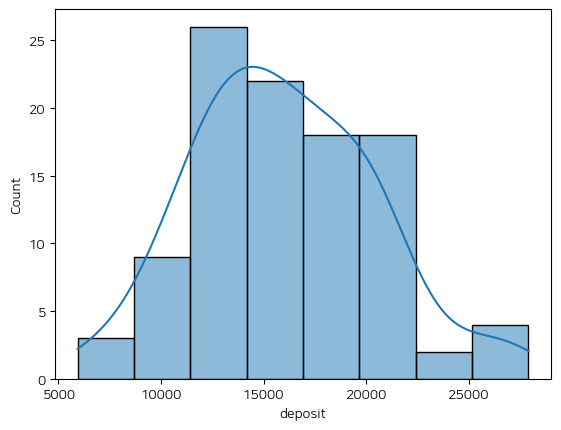

In [ ]:
sns.histplot(data = final_reduced, x='deposit', kde=True)